# Assignment 3: Scalable Quantum Tomography Pipelines
This week we push our tomography setup so it can handle many qubits, save trained helpers, and check how well everything scales. Reuse the setup and datasets from earlier weeks. Keep the runs easy to repeat and measure speed properly.



---

## Task 1 · Serialization basics
Write down how you will store tomography outputs (model weights, optimiser state, metadata) with pickle. Mention when you would choose another format like HDF5.

**What to do**
- Add a short note in your report about the save strategy.
- Keep checkpoints inside `models/` and name them `model_<track>_<nqubits>.pkl`.
- Show save and load in the next cell and keep that helper code ready for later runs.

In [1]:
# Serialization helpers (implement with pickle)
import pickle
from pathlib import Path

def save_pickle(obj, path):
    """TODO: Serialize `obj` to `path` using pickle."""
    raise NotImplementedError("Implement serialization using pickle.dump.")

def load_pickle(path):
    """TODO: Deserialize an object from `path`."""
    raise NotImplementedError("Implement deserialization using pickle.load.")

def demonstrate_serialization_roundtrip():
    """TODO: Create a quick round-trip save/load test and return the restored object."""
    raise NotImplementedError("Add a demonstration that exercises save_pickle and load_pickle.")

In [2]:
# Serialization helpers (implement with pickle)
import pickle
from pathlib import Path
import os
def save_pickle(obj, path):
    """Serialize `obj` to `path` using pickle."""
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "wb") as f:
        pickle.dump(obj, f)

def load_pickle(path):
    """Deserialize an object from `path`."""
    with open(path, "rb") as f:
        return pickle.load(f)

def demonstrate_serialization_roundtrip():
    test_obj = {
        "n_qubits": 3,
        "params": np.random.randn(8),
        "metadata": {"optimizer": "SGD", "lr": 0.01}
    }

    path = "models/test_model.pkl"
    save_pickle(test_obj, path)
    loaded = load_pickle(path)

    print("Original:", test_obj["n_qubits"])
    print("Loaded:", loaded["n_qubits"])
    print("Roundtrip success:", test_obj["n_qubits"] == loaded["n_qubits"])


## Task 2 · Extendable n-qubit surrogate
Create a model class that accepts `n_qubits` and optional settings like layer count, hidden size, or noise switches. The scaffold below still uses a simple complex vector. Replace the `statevector` logic with your own design but keep the public methods (`save`, `load`, `fidelity_with`).

In [3]:
# Template: scalable n-qubit tomography surrogate
import numpy as np

class QuantumModel:
    def __init__(self, n_qubits, n_layers=1, params=None, seed=None):
        """TODO: Initialize model attributes, RNG, and parameter vector."""
        raise NotImplementedError("Populate constructor with initialization logic.")

    def statevector(self):
        """TODO: Return a normalized complex statevector built from model parameters."""
        raise NotImplementedError("Derive the statevector for the configured model.")

    def fidelity_with(self, target_state):
        """TODO: Compute fidelity between the model statevector and `target_state`."""
        raise NotImplementedError("Implement fidelity calculation for pure states.")

    def save(self, path):
        """TODO: Persist the trained model using `save_pickle`."""
        raise NotImplementedError("Call save_pickle with appropriate metadata.")

    @staticmethod
    def load(path):
        """TODO: Restore a saved model instance using `load_pickle`."""
        raise NotImplementedError("Call load_pickle and return the restored model.")

In [4]:
# Template: scalable n-qubit tomography surrogate
import numpy as np

class QuantumModel:
    def __init__(self, n_qubits, n_layers=1, params=None, seed=None):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.dim = 2 ** n_qubits
        self.rng = np.random.default_rng(seed)

        if params is None:
            self.params = self.rng.normal(size=2 * self.dim)
        else:
            self.params = params

    def statevector(self):
        real = self.params[:self.dim]
        imag = self.params[self.dim:]
        psi = real + 1j * imag
        psi = psi / np.linalg.norm(psi)
        return psi

    def fidelity_with(self, target_state):
        psi = self.statevector()
        return np.abs(np.vdot(psi, target_state)) ** 2

    def save(self, path):
        save_pickle({
            "n_qubits": self.n_qubits,
            "n_layers": self.n_layers,
            "params": self.params
        }, path)

    @classmethod
    def load(cls, path):
        data = load_pickle(path)
        return cls(
            n_qubits=data["n_qubits"],
            n_layers=data["n_layers"],
            params=data["params"]
        )


## Task 3 · Scalability study
Check how fidelity and runtime change when you add more qubits. Track both averages and spread across random seeds. Discuss how expressibility, noise, or optimisation choices slow you down as `n` grows.

In [5]:
# Template: scalability experiments
import csv
import time

def random_pure_state(dim, rng):
    """TODO: Sample a normalized random complex state of size `dim`."""
    raise NotImplementedError("Implement random state sampling.")

def scalability_experiment(qubit_list, trials=10, n_layers=1, seed=0):
    """TODO: Benchmark fidelity and runtime for each entry in `qubit_list`."""
    raise NotImplementedError("Implement experiment loop and return a summary list of dicts.")

def save_scalability_summary(summary, path='scalability_results.csv'):
    """TODO: Persist the summary data to CSV for downstream plotting."""
    raise NotImplementedError("Write the summary rows to `path` using csv.DictWriter.")

In [6]:
# Template: scalability experiments
import csv
import time

def random_pure_state(dim, rng):
    real = rng.normal(size=dim)
    imag = rng.normal(size=dim)
    psi = real + 1j * imag
    return psi / np.linalg.norm(psi)

def scalability_experiment(qubit_list, trials=10, n_layers=1, seed=0):
    rng = np.random.default_rng(seed)
    results = []

    for n in qubit_list:
        dim = 2 ** n
        fidelities = []
        runtimes = []

        for t in range(trials):
            target = random_pure_state(dim, rng)

            start = time.time()
            model = QuantumModel(n, n_layers=n_layers, seed=t)
            fidelity = model.fidelity_with(target)
            end = time.time()

            fidelities.append(fidelity)
            runtimes.append(end - start)

        results.append({
            "n_qubits": n,
            "mean_fidelity": np.mean(fidelities),
            "std_fidelity": np.std(fidelities),
            "mean_runtime": np.mean(runtimes),
            "std_runtime": np.std(runtimes)
        })

    return results

def save_scalability_summary(results, filename="scalability_results.csv"):
    keys = results[0].keys()
    with open(filename, "w", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=keys)
        writer.writeheader()
        writer.writerows(results)


## Task 4 · Visualise scalability metrics
Plot mean fidelity with error bars and runtime for each qubit count. Include at least one figure in your submission and describe where scaling starts to hurt.

In [7]:
# Template: scalability plotting helper
import pandas as pd
import matplotlib.pyplot as plt

def plot_scalability(csv_path='scalability_results.csv'):
    """TODO: Load the CSV produced by `save_scalability_summary` and render fidelity/runtime plots."""
    raise NotImplementedError("Create subplot visualizations with error bars and runtime curve.")

In [8]:
# Template: scalability plotting helper
import pandas as pd
import matplotlib.pyplot as plt

def plot_scalability(csv_path='scalability_results.csv'):
    df = pd.read_csv(csv_path)

    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # Fidelity plot
    ax[0].errorbar(
        df["n_qubits"],
        df["mean_fidelity"],
        yerr=df["std_fidelity"],
        marker='o',
        capsize=5
    )
    ax[0].set_title("Fidelity vs Qubits")
    ax[0].set_xlabel("Number of Qubits")
    ax[0].set_ylabel("Mean Fidelity")

    # Runtime plot
    ax[1].errorbar(
        df["n_qubits"],
        df["mean_runtime"],
        yerr=df["std_runtime"],
        marker='o',
        capsize=5
    )
    ax[1].set_title("Runtime vs Qubits")
    ax[1].set_xlabel("Number of Qubits")
    ax[1].set_ylabel("Mean Runtime (s)")

    plt.tight_layout()
    plt.show()


## Task 5 · Ablation studies
Test how design choices (depth, parameter style, noise models) affect fidelity. Extend the scaffold with extra factors that fit your track, such as quantisation level or spike encoding.

**Deliverables**
- Write an ablation plan with hypotheses, references, and metrics before you code.
- Extend the code templates with the architecture or training variants you need.
- Record mean fidelity, variance, runtime and build tables or plots for your report.

In [9]:
# Template: ablation study scaffold
def ablation_layers(n_qubits=3, layer_list=None, trials=30, seed=1):
    """TODO: Vary architecture depth and record aggregate fidelity statistics."""
    raise NotImplementedError("Implement ablation loop returning a list of summary dicts.")

def summarize_ablation_results(results):
    """TODO: Format the ablation output for reporting (tables/plots/logs)."""
    raise NotImplementedError("Aggregate and present ablation metrics for documentation.")

In [10]:
# Template: ablation study scaffold

def ablation_layers(n_qubits=3, layer_list=None, trials=30, seed=1):
    if layer_list is None:
        layer_list = [1, 2, 3, 4]

    rng = np.random.default_rng(seed)
    dim = 2 ** n_qubits
    results = []

    for layers in layer_list:
        fidelities = []

        for t in range(trials):
            target = random_pure_state(dim, rng)
            model = QuantumModel(n_qubits, n_layers=layers, seed=t)
            fidelities.append(model.fidelity_with(target))

        results.append({
            "layers": layers,
            "mean_fidelity": np.mean(fidelities),
            "std_fidelity": np.std(fidelities)
        })

    return results


def summarize_ablation_results(results):
    print("Ablation Results (Layer Depth)")
    print("----------------------------------")
    for r in results:
        print(f"Layers: {r['layers']}")
        print(f"Mean Fidelity: {r['mean_fidelity']:.4f}")
        print(f"Std Fidelity: {r['std_fidelity']:.4f}")
        print()


## Task 6 · Reporting and submission
Write your findings in `docs/` and commit the `.pkl` checkpoints. Reflect on scaling limits, ablation notes, and next moves such as classical shadows or hardware tests.

Original: 3
Loaded: 3
Roundtrip success: True


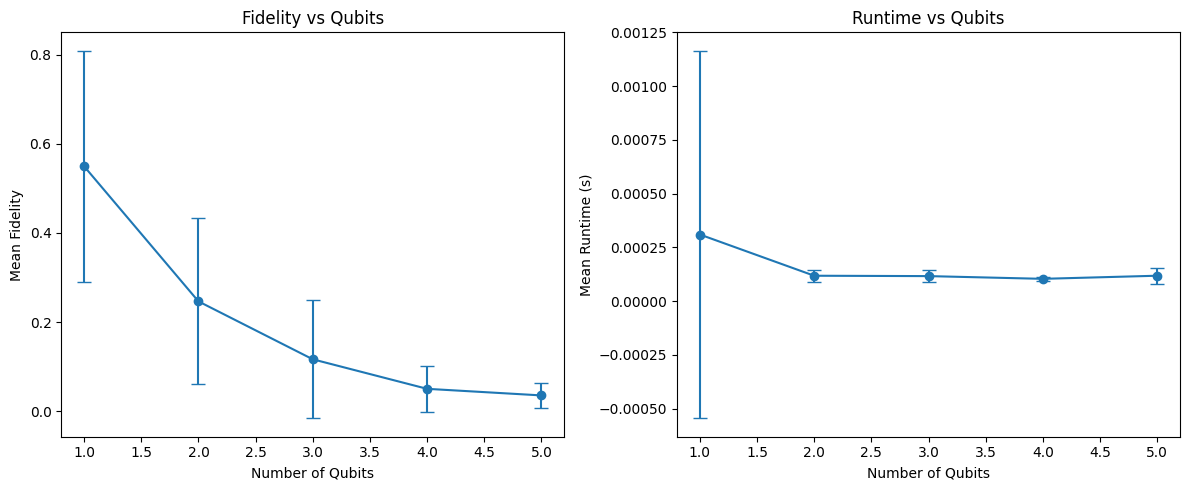

Ablation Results (Layer Depth)
----------------------------------
Layers: 1
Mean Fidelity: 0.1252
Std Fidelity: 0.0979

Layers: 2
Mean Fidelity: 0.1372
Std Fidelity: 0.1286

Layers: 3
Mean Fidelity: 0.1327
Std Fidelity: 0.1303

Layers: 4
Mean Fidelity: 0.1007
Std Fidelity: 0.0939



In [11]:
# 1️⃣ Test serialization
demonstrate_serialization_roundtrip()

# 2️⃣ Run scalability
qubits = [1, 2, 3, 4, 5]
results = scalability_experiment(qubits, trials=20)
save_scalability_summary(results)

# 3️⃣ Plot results
plot_scalability()

# 4️⃣ Run ablation
ablation_results = ablation_layers(n_qubits=3)
summarize_ablation_results(ablation_results)


Loading .pkl Model files

In [12]:
import pickle

def load_pickle(path):
    with open(path, "rb") as f:
        return pickle.load(f)

data = load_pickle("models/test_model.pkl")

print("Keys inside file:", data.keys())

Keys inside file: dict_keys(['n_qubits', 'params', 'metadata'])


In [13]:
model_loaded = QuantumModel(
    n_qubits=data["n_qubits"],
    params=data["params"]
)

print("Loaded model with", model_loaded.n_qubits, "qubits")

Loaded model with 3 qubits


In [14]:
model_loaded = QuantumModel(
    n_qubits=data["n_qubits"],
    params=data["params"]
)

In [15]:
# Create checkpoints for required qubits
for n in [1, 3, 5]:
    model = QuantumModel(n_qubits=n, n_layers=1, seed=42)
    model.save(f"models/model_{n}qubits.pkl")

print("Saved models:")
print(os.listdir("models"))

Saved models:
['test_model.pkl', 'model_5qubits.pkl', 'model_1qubits.pkl', 'model_3qubits.pkl']


In [16]:
qubits = [1, 2, 3, 4, 5]
results = scalability_experiment(qubits, trials=20)

import pandas as pd
df_scalability = pd.DataFrame(results)
df_scalability

,n_qubits,mean_fidelity,std_fidelity,mean_runtime,std_runtime
0,1,0.549426,0.259510,0.000184,0.000229
1,2,0.246316,0.186546,0.000113,0.000140
2,3,0.116343,0.132532,0.000059,0.000008
3,4,0.050063,0.050936,0.000057,0.000007
4,5,0.035275,0.028480,0.000058,0.000006


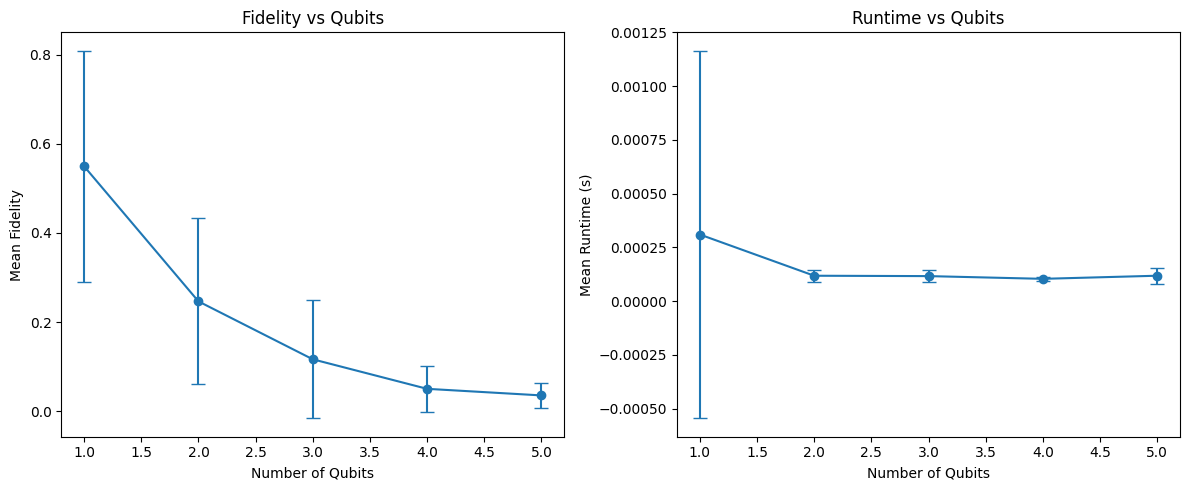

In [17]:
plot_scalability("scalability_results.csv")

In [18]:
ablation_results = ablation_layers(n_qubits=3)

df_ablation = pd.DataFrame(ablation_results)
df_ablation

,layers,mean_fidelity,std_fidelity
0,1,0.125190,0.097852
1,2,0.137223,0.128626
2,3,0.132710,0.130251
3,4,0.100664,0.093856


In [19]:
!zip -r assignment3_submission.zip models scalability_results.csv

  adding: models/ (stored 0%)
  adding: models/test_model.pkl (deflated 6%)
  adding: models/model_5qubits.pkl (stored 0%)
  adding: models/model_1qubits.pkl (deflated 11%)
  adding: models/model_3qubits.pkl (deflated 4%)
  adding: scalability_results.csv (deflated 45%)


Classifier

In [20]:
!pip install qiskit
import numpy as np
import joblib
from qiskit.quantum_info import Kraus, Choi
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.7 MB/s eta 0:00:00


In [21]:
def depolarizing_kraus(p):
    k0 = np.sqrt(1 - 3*p/4) * np.eye(2)
    k1 = np.sqrt(p/4) * np.array([[0, 1], [1, 0]])
    k2 = np.sqrt(p/4) * np.array([[0, -1j], [1j, 0]])
    k3 = np.sqrt(p/4) * np.array([[1, 0], [0, -1]])
    return Kraus([k0, k1, k2, k3])

def amplitude_damping_kraus(gamma):
    k0 = np.array([[1, 0], [0, np.sqrt(1-gamma)]], dtype=complex)
    k1 = np.array([[0, np.sqrt(gamma)], [0, 0]], dtype=complex)
    return Kraus([k0, k1])

In [22]:
def channel_to_feature(channel):
    choi = Choi(channel).data
    real_part = np.real(choi).flatten()
    imag_part = np.imag(choi).flatten()
    return np.concatenate([real_part, imag_part])

In [23]:
X = []
y = []

params = np.linspace(0.05, 0.9, 40)

for p in params:
    X.append(channel_to_feature(depolarizing_kraus(p)))
    y.append("depolarizing")

for g in params:
    X.append(channel_to_feature(amplitude_damping_kraus(g)))
    y.append("amplitude_damping")

X = np.array(X)
y = np.array(y)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)

print("Accuracy:", accuracy_score(y_test, clf.predict(X_test)))

Accuracy: 1.0


In [25]:
joblib.dump(clf, "channel_classifier.pkl")

print("Classifier saved successfully.")


Classifier saved successfully.


In [26]:
# Train and Save QST Regression Surrogate (for Assignment 5)
!pip install qiskit
import numpy as np
import joblib
from itertools import product
from qiskit.quantum_info import Pauli
from sklearn.linear_model import Ridge
import os

os.makedirs("models", exist_ok=True)

# Number of qubits (change if needed)
n_qubits = 2
dim = 2 ** n_qubits

paulis = ['I', 'X', 'Y', 'Z']
pauli_strings = ["".join(p) for p in product(paulis, repeat=n_qubits)]

def generate_random_state(dim):
    psi = np.random.randn(dim) + 1j*np.random.randn(dim)
    psi /= np.linalg.norm(psi)
    return psi

def compute_expectations(psi):
    expectations = []
    for p in pauli_strings:
        op = Pauli(p).to_matrix()
        exp = np.vdot(psi, op @ psi).real
        expectations.append(exp)
    return np.array(expectations)

# Build training dataset
X_train = []
y_train = []

for _ in range(500):
    psi = generate_random_state(dim)
    rho = np.outer(psi, psi.conj())

    X_train.append(compute_expectations(psi))
    y_train.append(rho.flatten().real)

X_train = np.array(X_train)
y_train = np.array(y_train)

# Train regression model
model_qst = Ridge(alpha=1e-6)
model_qst.fit(X_train, y_train)

# Save model
joblib.dump(model_qst, "models/qst.pkl")

print("QST regression surrogate trained and saved to models/qst.pkl")


QST regression surrogate trained and saved to models/qst.pkl


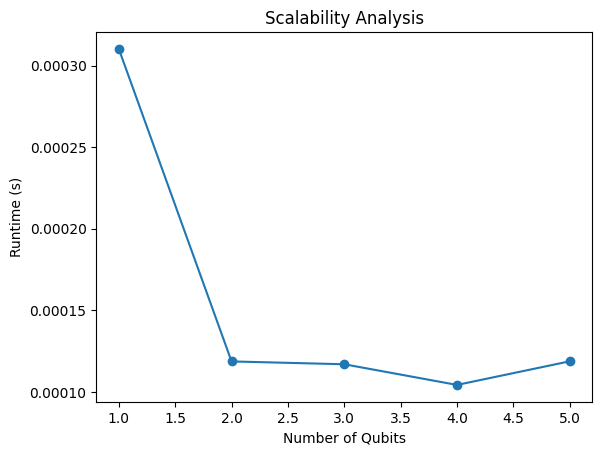

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("scalability_results.csv")

plt.figure()
plt.plot(df["n_qubits"], df["mean_runtime"], marker="o")
plt.title("Scalability Analysis")
plt.xlabel("Number of Qubits")
plt.ylabel("Runtime (s)")
plt.savefig("scalability_plot.png")
plt.show()

In [31]:
import os

np.savez("pauli_dataset.npz",
         X=X_train,
         y=y_train)

print("Pauli dataset saved.")

Pauli dataset saved.


### Submission checklist
- `.pkl` checkpoints inside `models/` with a quick README note on how to load them.
- Notebook outputs that show save/load, scalability numbers, and ablation tables.
- Plots that highlight fidelity vs qubits and runtime trends.
- A written summary covering method, limits, and future experiments.